<a href="https://colab.research.google.com/github/NirajBagh/ERD-ERS-Brain-Patterns-in-Brain-Computer-Interface/blob/master/EEG_based_Eye_Blink_Detector_Using_Machine_Learning_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import the Libraries #

In [174]:
import math
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from time import time
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels
from sklearn import datasets, neighbors, linear_model, tree
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, svm
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

#Access the Google drive in Colab#

In [175]:
## Acess google drive to colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [176]:
#importing datasets
Data= pd.read_csv('/content/drive/MyDrive/Blinks and No Blinks Data/Blinks and No Blinks Data.csv')

In [177]:
Data.shape

(23200, 18)

In [178]:
#viewing normal dataset
Data.head()

,U-Ch1,U-Ch2,U-Ch3,U-Ch4,U-Ch5,U-Ch6,U-Ch7,U-Ch8,Ch1,Ch-2,Ch-3,Ch-4,Ch-5,Ch-6,Ch-7,Ch-8,Blink Type,Experiment
0,-1374525,-1373923,234660,-834945,-1072409,-1027019,-1225566,-808635,-12.628689,-12.578017,0.667327,5.951678,-22.945999,-11.547135,-1.056227,3.862016,0,2
1,-1374573,-1373967,234570,-834960,-1072445,-1027119,-1225846,-808671,-16.473428,-15.084587,0.209305,7.601201,-20.144410,-9.043147,0.059553,4.243434,0,2
2,-1374666,-1374059,234606,-834990,-1072505,-1027135,-1224796,-808617,-19.158531,-16.168834,0.284056,9.079308,-17.915681,-7.286557,1.082064,4.579486,0,2
3,-1374693,-1374095,234654,-834984,-1072508,-1027059,-1224250,-808590,-21.402139,-16.788590,0.397129,10.056994,-16.240168,-6.158297,2.524490,4.438789,0,2
4,-1374639,-1374083,234621,-834969,-1072493,-1027039,-1224642,-808620,-23.506191,-17.690812,-0.107802,10.612097,-15.129963,-5.564709,3.079255,3.815446,0,2


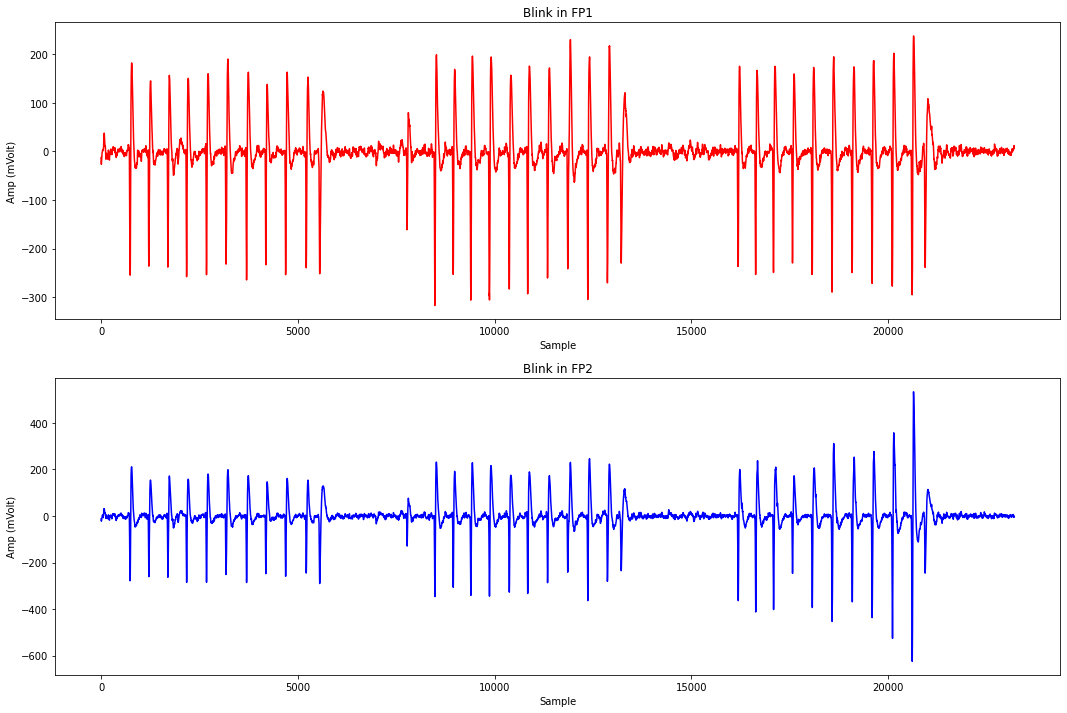

In [179]:
plt.figure(figsize=(18,12))

plt.subplot(2,1,1)
plt.plot(Data.iloc[:,8],'r')
plt.xlabel('Sample')
plt.ylabel('Amp (mVolt)')
plt.title('Blink in FP1')

plt.subplot(2,1,2)
plt.plot(Data.iloc[:,9],'b')
plt.xlabel('Sample')
plt.ylabel('Amp (mVolt)')
plt.title('Blink in FP2')
plt.show()

In [180]:
Level=Data.iloc[:,16]; # class label: 0-> No Blink and 1->Blink
#Level.head

In [181]:
Level.shape

(23200,)

In [182]:
Filtered_Data=Data.iloc[:,8:10] # Extract signals from FP1 and FP2
#type(Filtered_Data), type(Level)
#print(Filtered_Data)

In [183]:
New_Data=[Filtered_Data,Level] # Concate signals and their corrosponding level
New_New_Data = pd.concat(New_Data, axis=1)
#print(New_New_Data)
#New_New_Data.head

# Eye Blinks and No Blinks Extractions #

In [184]:
No_Blink_Data=New_New_Data[New_New_Data['Blink Type']==0] #No Blink Data
Blink_Data=New_New_Data[New_New_Data['Blink Type']==1] #Blink Data
#print(No_Blink_Data), print(No_Blink_Data.shape)
#print(Blink_Data), print(Blink_Data.shape)

# Plot Eye Blinks and No Blinks Signals #

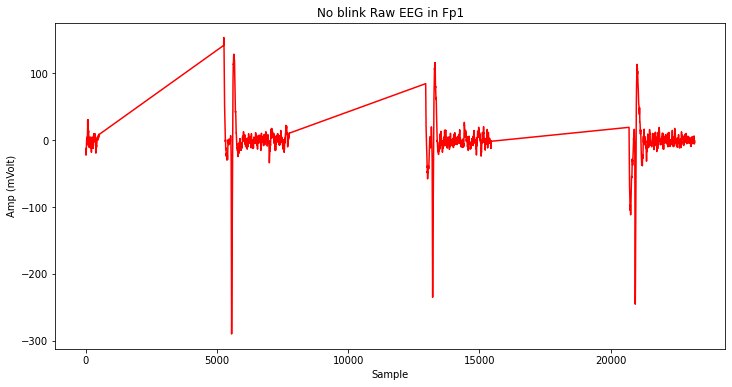

In [185]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(No_Blink_Data.iloc[:,1],'r')
plt.title("No blink Raw EEG in Fp1")
plt.xlabel('Sample')
plt.ylabel('Amp (mVolt)')
plt.show()

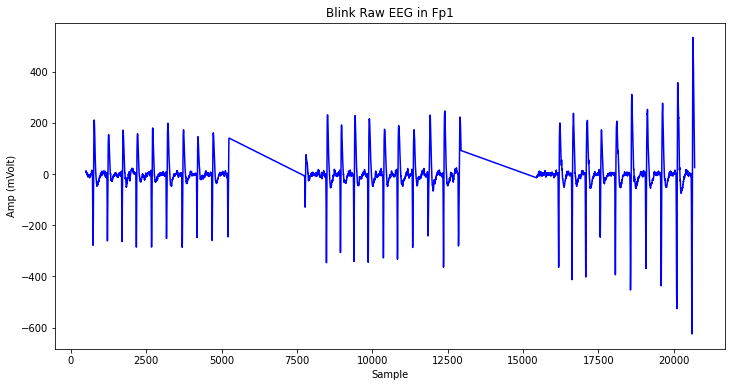

In [186]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(Blink_Data.iloc[:,1],'b')
plt.title("Blink Raw EEG in Fp1")
plt.xlabel('Sample')
plt.ylabel('Amp (mVolt)')
plt.show()

#Slidding window technique to extract EEG epoches #

In [187]:
def buffer(data,duration,dataOverlap):
    numberOfSegments = int(math.ceil((len(data)-dataOverlap)/(duration-dataOverlap)))
    #print(data.shape)
    tempBuf = [data[i:i+duration] for i in range(0,len(data),(duration-int(dataOverlap)))]
    tempBuf[numberOfSegments-1] = np.pad(tempBuf[numberOfSegments-1],(0,duration-tempBuf[numberOfSegments-1].shape[0]),'constant')
    tempBuf2 = np.vstack(tempBuf[0:numberOfSegments])
    return tempBuf2

In [188]:
sampleRate=500
windowLen=1
shiftLen=1
duration=int(windowLen*sampleRate)
dataOverlap = (windowLen-shiftLen)*sampleRate
print(duration), print(dataOverlap)
Seg_NO_Blink_FP1=buffer(No_Blink_Data.iloc[:,0],duration,dataOverlap)
Seg_NO_Blink_FP2=buffer(No_Blink_Data.iloc[:,1],duration,dataOverlap)
print(Seg_NO_Blink_FP1.shape),print(Seg_NO_Blink_FP2.shape)
#print(Seg_NO_Blink_FP1[0,:])

500
0
(16, 500)
(16, 500)


(None, None)

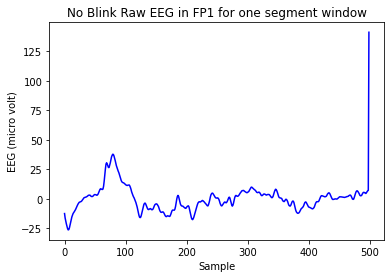

In [189]:
import matplotlib.pyplot as plt
plt.plot(Seg_NO_Blink_FP1[0,:],'b')
plt.title("No Blink Raw EEG in FP1 for one segment window")
plt.xlabel('Sample')
plt.ylabel('EEG (micro volt)')
plt.show()

In [190]:
Seg_Blink_FP1=buffer(Blink_Data.iloc[:,0],duration,dataOverlap)
Seg_Blink_FP2=buffer(Blink_Data.iloc[:,1],duration,dataOverlap)
print(Seg_Blink_FP1.shape),print(Seg_Blink_FP2.shape)

(31, 500)
(31, 500)


(None, None)

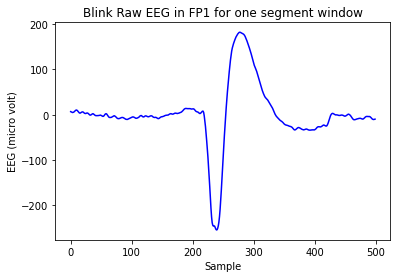

In [191]:
import matplotlib.pyplot as plt
plt.plot(Seg_Blink_FP1[0,:],'b')
plt.title("Blink Raw EEG in FP1 for one segment window")
plt.xlabel('Sample')
plt.ylabel('EEG (micro volt)')
plt.show()

#Feature Matrix For No Blinks#

In [192]:
import math 
Min_no_blink_Fp1_New=[]
Min_no_blink_Fp2_New=[]
Max_no_blink_Fp1_New=[]
Max_no_blink_Fp2_New=[]
for i in range(16):
  Min_no_blink_Fp1=np.min(Seg_NO_Blink_FP1[i,:])
  Max_no_blink_Fp1=np.max(Seg_NO_Blink_FP1[i,:])
  Min_no_blink_Fp2=np.min(Seg_NO_Blink_FP2[i,:])
  Max_no_blink_Fp2=np.max(Seg_NO_Blink_FP2[i,:])
  Min_no_blink_Fp1_New.append(Min_no_blink_Fp1)
  Min_no_blink_Fp2_New.append(Min_no_blink_Fp2)
  Max_no_blink_Fp1_New.append(Max_no_blink_Fp1)
  Max_no_blink_Fp2_New.append(Max_no_blink_Fp2)
  

In [193]:
l1=len(Min_no_blink_Fp1_New)
Feature_No_Blink=[Max_no_blink_Fp1_New,Min_no_blink_Fp1_New,Max_no_blink_Fp2_New,Max_no_blink_Fp2_New]
type(Feature_No_Blink), print(Feature_No_Blink)

[[141.2001773, 152.9526965, 9.730080155, 10.66690299, 21.00020789, 81.45359276, 120.8272411, 11.68224507, 17.58072468, 14.47804106, 23.42332723, 108.3893392, 13.13654702, 14.26761902, 15.17128618, 14.92996924], [-26.50358799, -251.3237038, -22.58112607, -14.20786551, -29.15993463, -21.93015922, -229.5811875, -20.92842338, -11.19945858, -19.27993209, -17.13537572, -238.4512911, -35.86327343, -10.75386519, -9.517325299, -9.722532824], [142.0000542, 153.9073582, 12.77176241, 11.25102164, 17.74609962, 84.74290285, 115.9900082, 15.12628377, 26.78608801, 14.58865226, 20.32482173, 113.6472141, 16.5937775, 19.24867866, 17.75275165, 11.70363387], [142.0000542, 153.9073582, 12.77176241, 11.25102164, 17.74609962, 84.74290285, 115.9900082, 15.12628377, 26.78608801, 14.58865226, 20.32482173, 113.6472141, 16.5937775, 19.24867866, 17.75275165, 11.70363387]]


(list, None)

In [194]:
df= pd.DataFrame(Feature_No_Blink)

In [195]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,141.200177,152.952697,9.730080,10.666903,21.000208,81.453593,120.827241,11.682245,17.580725,14.478041,23.423327,108.389339,13.136547,14.267619,15.171286,14.929969
1,-26.503588,-251.323704,-22.581126,-14.207866,-29.159935,-21.930159,-229.581187,-20.928423,-11.199459,-19.279932,-17.135376,-238.451291,-35.863273,-10.753865,-9.517325,-9.722533
2,142.000054,153.907358,12.771762,11.251022,17.746100,84.742903,115.990008,15.126284,26.786088,14.588652,20.324822,113.647214,16.593778,19.248679,17.752752,11.703634
3,142.000054,153.907358,12.771762,11.251022,17.746100,84.742903,115.990008,15.126284,26.786088,14.588652,20.324822,113.647214,16.593778,19.248679,17.752752,11.703634


In [196]:
No_Blink_Features= df.T
No_Blink_Features.shape
class_1= pd.DataFrame(np.zeros((l1, 1)))
NO_BLINK=pd.concat([No_Blink_Features, class_1], axis=1)
NO_BLINK.head()
NO_BLINK.shape

(16, 5)

#Feature Matrix For Blink #

In [197]:
Min_blink_Fp1_New=[]
Min_blink_Fp2_New=[]
Max_blink_Fp1_New=[]
Max_blink_Fp2_New=[]
for i in range(31):
  Min_blink_Fp1=np.min(Seg_Blink_FP1[i,:])
  Max_blink_Fp1=np.max(Seg_Blink_FP1[i,:])
  Min_blink_Fp2=np.min(Seg_Blink_FP2[i,:])
  Max_blink_Fp2=np.max(Seg_Blink_FP2[i,:])
  Min_blink_Fp1_New.append(Min_blink_Fp1)
  Min_blink_Fp2_New.append(Min_blink_Fp2)
  Max_blink_Fp1_New.append(Max_blink_Fp1)
  Max_blink_Fp2_New.append(Max_blink_Fp2)
  

In [198]:
Feature_Blink=[Max_blink_Fp1_New,Min_blink_Fp1_New,Max_blink_Fp2_New,Max_blink_Fp2_New]
df1= pd.DataFrame(Feature_Blink)
Blink_Features= df1.T
l2=len(Min_blink_Fp1_New)
class_2= pd.DataFrame(np.ones((l2, 1)))
BLINK=pd.concat([Blink_Features, class_2], axis=1)
BLINK.head()

,0,1,2,3,0
0,182.000285,-254.392448,211.296305,211.296305,1.0
1,145.160796,-235.888508,154.202753,154.202753,1.0
2,156.400876,-237.736155,171.798458,171.798458,1.0
3,150.298553,-257.505095,158.068147,158.068147,1.0
4,159.852329,-253.351211,180.091969,180.091969,1.0


#Merge Features of No Blinks and Blinks #

In [199]:
NO_BLINK_BLINK_Features=pd.concat([NO_BLINK, BLINK], axis=0)
#type(NO_BLINK_BLINK_Features)
NO_BLINK_BLINK_Features.columns = ["Fp1_Max", "Fp1_Min", "Fp2_max", "Fp2_Min","Class_Label"]
NO_BLINK_BLINK_Features.head()
#NO_BLINK_BLINK_Features.shape[0]

,Fp1_Max,Fp1_Min,Fp2_max,Fp2_Min,Class_Label
0,141.200177,-26.503588,142.000054,142.000054,0.0
1,152.952697,-251.323704,153.907358,153.907358,0.0
2,9.730080,-22.581126,12.771762,12.771762,0.0
3,10.666903,-14.207866,11.251022,11.251022,0.0
4,21.000208,-29.159935,17.746100,17.746100,0.0


# Split Data for training and testing #

In [200]:
#splitting the datasets for training and testing process
from sklearn.model_selection import train_test_split
x = NO_BLINK_BLINK_Features.drop("Class_Label", axis=1) # Features
y = NO_BLINK_BLINK_Features["Class_Label"]  # class label
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=42)

In [201]:
#size for the sets
print('size of X_train:', X_train.shape)
print('size of X_test:', X_test.shape)
print('size of y_train:', y_train.shape)
print('size of y_test:', y_test.shape)

size of X_train: (35, 4)
size of X_test: (12, 4)
size of y_train: (35,)
size of y_test: (12,)


#KNN Model #

In [202]:
#1-KNN
import time
print('#1-KNN')
start=time.time()
model = neighbors.KNeighborsClassifier(n_neighbors = 20)
# model.fit(X_train, y_train)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
# y_pred = model.predict(X)
print (metrics.accuracy_score(y_test, y_test_pred, normalize=True, sample_weight=None)*100)
end=time.time()
print("Time taken=",end-start)

#1-KNN
91.66666666666666
Time taken= 0.016866445541381836


#Naive Bayes #

In [203]:
# GaussianNB
print('#7-GaussianNB')
start=time.time()
model = GaussianNB()
model.fit(X_train, y_train)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print(metrics.accuracy_score(y_test, y_test_pred, normalize=True, sample_weight=None)*100)
end=time.time()
print("Time taken=",end-start)

#7-GaussianNB
83.33333333333334
Time taken= 0.013131141662597656


#Logistic Regression # 

In [204]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
#Building classification models
#names = ['FP1_max', 'FP1_min', 'FP2_max', 'FP2_min', 'Max_diff', 'Min_diff']
#   ****************Logistic Regression*****************
logReg = LogisticRegression(random_state=0, solver='liblinear')
logReg.fit(X_train, y_train)
#Check accuracy of Logistic Regression
y_pred_logReg = logReg.predict(X_test)
#Model Accuracy
print("Accuracy of logistic regression classifier :: " ,metrics.accuracy_score(y_test,y_pred_logReg)*100)

Accuracy of logistic regression classifier ::  75.0


#Repeated KFold CV Techniques#

# 1. Logistic Regression #

In [205]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores)*100, std(scores)))

Accuracy: 90.500 (0.162)


>1 mean=90.5000 se=0.054
>2 mean=92.2500 se=0.034
>3 mean=92.0000 se=0.027
>4 mean=91.5000 se=0.023
>5 mean=91.9000 se=0.019
>6 mean=91.0833 se=0.018
>7 mean=91.2143 se=0.017
>8 mean=91.5000 se=0.015
>9 mean=91.7222 se=0.014
>10 mean=91.7000 se=0.013
>11 mean=91.8636 se=0.013
>12 mean=92.0000 se=0.012
>13 mean=91.9615 se=0.012
>14 mean=91.8571 se=0.011
>15 mean=91.9667 se=0.011


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


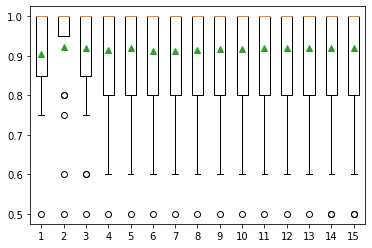

In [206]:
# compare the number of repeats for repeated k-fold cross-validation
from scipy.stats import sem
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
# evaluate a model with a given number of repeats
def evaluate_model(X, y, repeats):
	# prepare the cross-validation procedure
	cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
	# create model
	model = LogisticRegression()
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
repeats = range(1,16)
results = list()
for r in repeats:
	# evaluate using a given number of repeats
	scores = evaluate_model(x, y, r)
	# summarize
	print('>%d mean=%.4f se=%.3f' % (r, mean(scores)*100, sem(scores)))
	# store
	results.append(scores)
# plot the results
pyplot.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
pyplot.show()

# 2. SVM Model #

In [207]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
			'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, cv=5, verbose = 3)

# fitting the model for grid search
grid.fit(X_train, y_train)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.571 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.571 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.714 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.714 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.714 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.571 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.571 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.714 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.714 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.714 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.571 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [208]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)


{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=1, gamma=0.001)


In [209]:
grid_predictions = grid.predict(X_test)

# print classification report
print(classification_report(y_test, grid_predictions))


              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89         4
         1.0       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



#Save the SVM Model #

In [210]:
# Save Model Using Pickle
import pickle
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(grid, open(filename, 'wb'))

#Use saved Model #

In [211]:
# some time later...
# load the model from disk
filename='/content/finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result*100)

91.66666666666666


#Apply Unseen Data #

In [212]:
#importing datasets
Unseen_Data= pd.read_csv('/content/drive/MyDrive/Blinks and No Blinks Data/Unseen Data.csv')

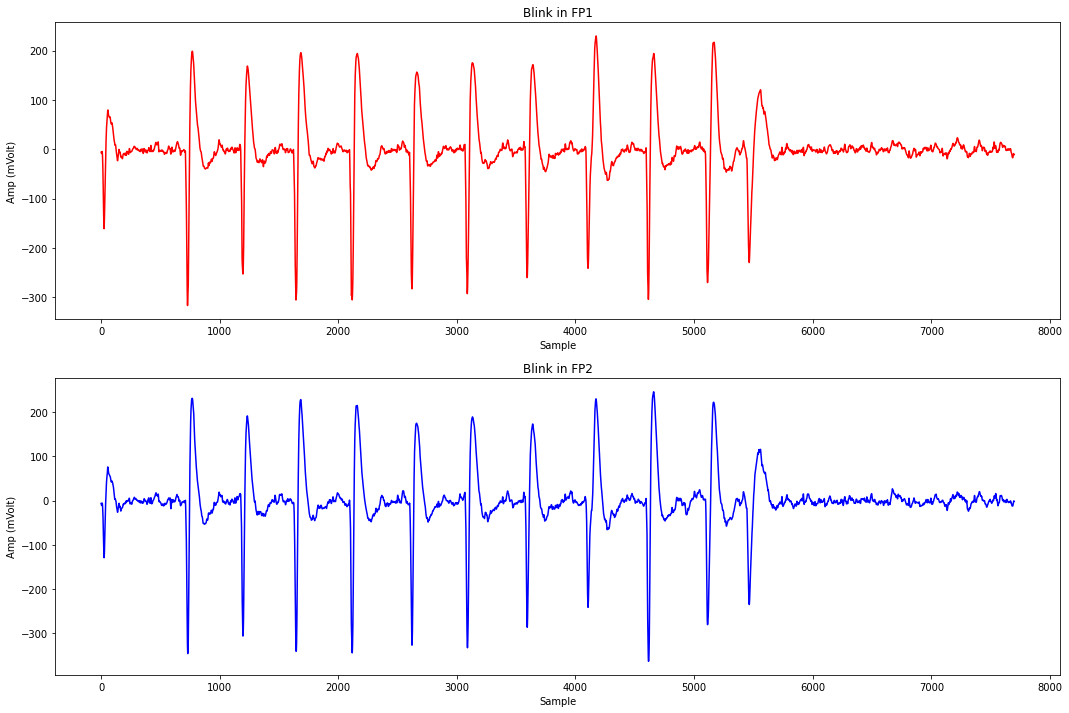

In [213]:
plt.figure(figsize=(18,12))

plt.subplot(2,1,1)
plt.plot(Unseen_Data.iloc[:,9],'r')
plt.xlabel('Sample')
plt.ylabel('Amp (mVolt)')
plt.title('Blink in FP1')

plt.subplot(2,1,2)
plt.plot(Unseen_Data.iloc[:,10],'b')
plt.xlabel('Sample')
plt.ylabel('Amp (mVolt)')
plt.title('Blink in FP2')
plt.show()

In [214]:
Unseen_Data_FP1=buffer(Unseen_Data.iloc[:,9],duration,dataOverlap)
Unseen_Data_FP2=buffer(Unseen_Data.iloc[:,10],duration,dataOverlap)
#print(Unseen_Data_FP1.shape),print(Unseen_Data_FP2.shape)
#print(Unseen_Data_FP2)
l3=len(Unseen_Data_FP1)

In [215]:
Min_Unseen_Data_FP1_New=[]
Max_Unseen_Data_FP1_New=[]
Min_Unseen_Data_FP2_New=[]
Max_Unseen_Data_FP2_New=[]
for i in range(l1):
  Min_Unseen_Data_FP1=np.min(Unseen_Data_FP1[i,:])
  Max_Unseen_Data_FP1=np.max(Unseen_Data_FP1[i,:])
  Min_Unseen_Data_FP2=np.min(Unseen_Data_FP2[i,:])
  Max_Unseen_Data_FP2=np.max(Unseen_Data_FP2[i,:])
  Min_Unseen_Data_FP1_New.append(Min_Unseen_Data_FP1)
  Min_Unseen_Data_FP2_New.append(Min_Unseen_Data_FP2)
  Max_Unseen_Data_FP1_New.append(Max_Unseen_Data_FP1)
  Max_Unseen_Data_FP2_New.append(Max_Unseen_Data_FP2)
  

In [216]:
Unseen_Data_Feature=[Max_Unseen_Data_FP1_New,Min_Unseen_Data_FP1_New,Max_Unseen_Data_FP2_New,Min_Unseen_Data_FP2_New]
type(Unseen_Data_Feature)
Unknown_feature= pd.DataFrame(Unseen_Data_Feature)
New_Unknown_Feature=(Unknown_feature.T)
type(New_Unknown_Feature)
New_Unknown_Feature.head()
New_Unknown_Feature.columns = ["Fp1_Max", "Fp1_Min", "Fp2_max", "Fp2_Min"]
New_Unknown_Feature.head()

,Fp1_Max,Fp1_Min,Fp2_max,Fp2_Min
0,79.761702,-160.910197,76.252170,-129.248473
1,198.830692,-316.717476,231.530433,-346.314552
2,168.794879,-252.733921,191.825756,-306.539612
3,196.016290,-305.598584,228.770322,-341.191398
4,194.301045,-305.287068,215.364129,-344.622144


#Predicting Class label for each window #

In [217]:
New_predictions = loaded_model.predict(New_Unknown_Feature)
print(New_predictions) # prediction of model for blink (class:1) and no blink (class:2)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0.]


# Plot figure of 1st window and verify whether its blink or no blink #

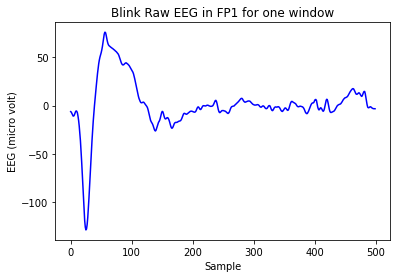

In [218]:
import matplotlib.pyplot as plt
plt.plot(Unseen_Data_FP2[0,:],'b') # its a blink signal
plt.title("Blink Raw EEG in FP1 for one window")
plt.xlabel('Sample')
plt.ylabel('EEG (micro volt)')
plt.show() 

# Check how many blinks and no blinks are there in unseen data and verify it with model predictions #

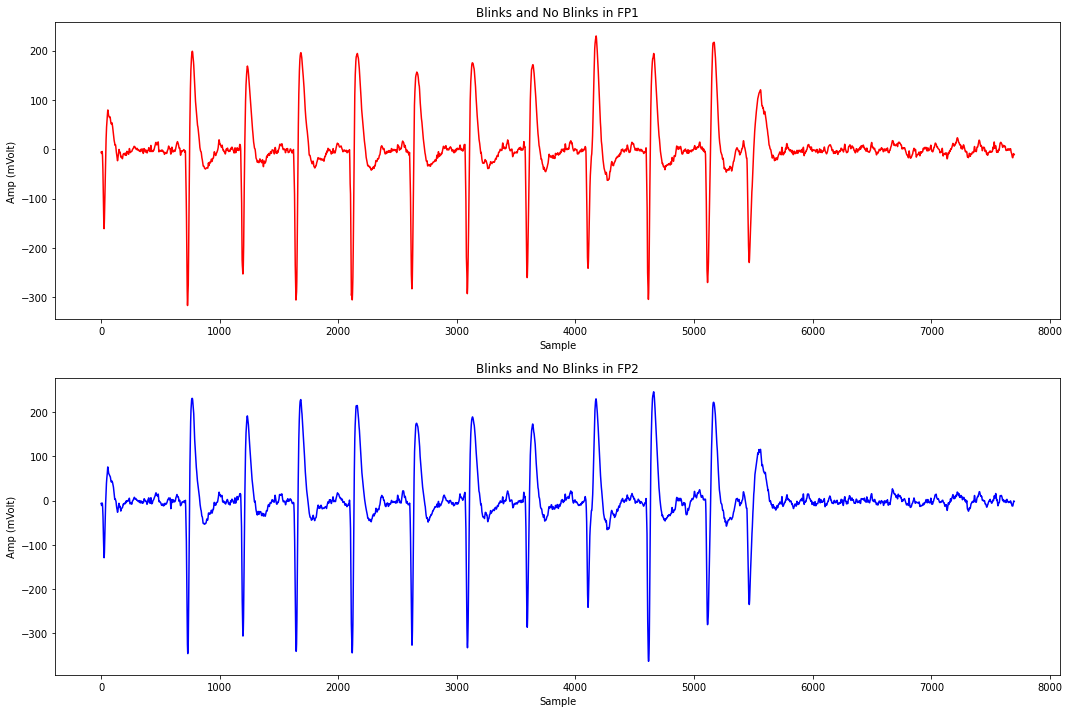

In [219]:
plt.figure(figsize=(18,12))

plt.subplot(2,1,1)
plt.plot(Unseen_Data.iloc[:,9],'r')
plt.xlabel('Sample')
plt.ylabel('Amp (mVolt)')
plt.title('Blinks and No Blinks in FP1')

plt.subplot(2,1,2)
plt.plot(Unseen_Data.iloc[:,10],'b')
plt.xlabel('Sample')
plt.ylabel('Amp (mVolt)')
plt.title('Blinks and No Blinks in FP2')
plt.show()